**Background:**

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

<img src="mobile.png" width=400 height=400 />

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor. 

**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.

**Install necessaries libraries**

In [2]:

import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys
import numpy as np
import cv2
import skvideo.io
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow import keras
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance


from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

import math   # for mathematical operations

import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

from moviepy.editor import VideoFileClip, concatenate_videoclips

2022-05-09 11:25:41.029458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amath/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-09 11:25:41.029478: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Data Wrangling**

In [3]:
# Establish the path to read all of the images 

path_training_flip = glob.glob('images/training/flip/*.jpg')

path_training_notflip = glob.glob('images/training/notflip/*.jpg')

path_testing_flip = glob.glob('images/testing/flip/*.jpg')

path_testing_notflip = glob.glob('images/testing/notflip/*.jpg')

**Data Preprocessing**

In [5]:
# Define a function that will do all the preprocessing for each image to be ready for modeling

def image_preprocessing(path):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in path:
        # Firstly read the image
        img = cv2.imread(i)
        # Adjust the size so all iamges will have the same size
        img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Normalize the images to be black and white by reverting the images and then dividing by 255.0
        img = cv2.bitwise_not(img)
        img = img/255

        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [6]:
# Read and preprocess the training data

img_training_flip = image_preprocessing(path = path_training_flip)

# Read the training not flip

img_training_notflip = image_preprocessing(path = path_training_notflip)

# Read the test flip

img_testing_flip = image_preprocessing(path = path_testing_flip)

# Read the test not flip

img_testing_notflip = image_preprocessing(path = path_testing_notflip)

In [7]:
# Define the labels for the problem

y_train_flip = [1 for i in range(0, len(img_training_flip))]

y_train_notflip = [0 for i in range(0, len(img_training_notflip))]

y_test_flip = [1 for i in range(0, len(img_testing_flip))]

y_test_notflip = [0 for i in range(0, len(img_testing_notflip))]

**Modeling**

In [8]:
# Define the X_train, X_test, y_train and y_test for analysis

X_train = np.concatenate((img_training_flip, img_training_notflip), axis = 0)

X_test = np.concatenate((img_testing_flip, img_testing_notflip), axis = 0)

y_train = np.append(y_train_flip, y_train_notflip)

y_test = np.append(y_test_flip, y_test_notflip)

In [9]:
# See if the shapes matches between the X_trian and y_train and the X_test and y_test

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2392, 100, 70, 3)
(2392,)
(597, 100, 70, 3)
(597,)


In [11]:
# Create a new array that will have the original arrays (labels and values) but they will be shuffled. 

# Create the array for the train data set

X_train_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_train):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_train[i])
    # Append the values to the array that will be shuffled
    X_train_shuffle.append(new_array)
    
# Have the new set of arrays
X_train_shuffle = np.array(X_train_shuffle)

In [12]:
# Create the array for the test data set

X_test_shuffle = []

# It is necessary to create a for loop with enumeration as well
for i,j in enumerate(X_test):
    # The new array would be the array containing the image plus its label 
    new_array = (j, y_test[i])
    # Append the values to the array that will be shuffled
    X_test_shuffle.append(new_array)
    
# Have the new set of arrays  
X_test_shuffle = np.array(X_test_shuffle)


In [13]:
# Apply the random shuffle to make the train and test with no specific order

np.random.shuffle(X_train_shuffle)

np.random.shuffle(X_test_shuffle)

In [14]:


# Separate between the X_train and y_train to fit the model

X_train = []
y_train = []

# Start a for loop into the X_train_shuffle
for i in X_train_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_train.append(value)
    y_train.append(label)

# Divide between X_train and y_train to run model
X_train = np.array(X_train)

y_train = np.array(y_train)



In [15]:


# Same for the test data set

X_test = []
y_test = []

# Start a for loop into the X_test_shuffle
for i in X_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    value = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test.append(value)
    y_test.append(label)

X_test = np.array(X_test)

y_test = np.array(y_test)



In [16]:
# Make sure labels are same than the first shapes

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2392, 100, 70, 3)
(2392,)
(597, 100, 70, 3)
(597,)


In [17]:
# Define a function with the neural networks

def neural_network():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
                     padding = 'same', input_shape=(100, 70, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# Fit model

model = neural_network()

# fit model
model.fit(X_train, y_train, epochs = 15)

2022-05-09 11:31:55.317645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/amath/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-09 11:31:55.317957: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 11:31:55.318722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (amath-Latitude-7490): /proc/driver/nvidia/version does not exist
2022-05-09 11:31:55.326325: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 11:31:55.4

Epoch 1/15


2022-05-09 11:31:58.945278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28672000 exceeds 10% of free system memory.


75/75 [==============================] - 22s 286ms/step - loss: 0.4025 - accuracy: 0.8257
Epoch 2/15
75/75 [==============================] - 5s 65ms/step - loss: 0.1609 - accuracy: 0.9594
Epoch 3/15
75/75 [==============================] - 4s 56ms/step - loss: 0.0957 - accuracy: 0.9816
Epoch 4/15
75/75 [==============================] - 4s 56ms/step - loss: 0.0692 - accuracy: 0.9862
Epoch 5/15
75/75 [==============================] - 5s 70ms/step - loss: 0.0516 - accuracy: 0.9937
Epoch 6/15
75/75 [==============================] - 5s 61ms/step - loss: 0.0384 - accuracy: 0.9950
Epoch 7/15
75/75 [==============================] - 4s 56ms/step - loss: 0.0309 - accuracy: 0.9975
Epoch 8/15
75/75 [==============================] - 4s 56ms/step - loss: 0.0257 - accuracy: 0.9983
Epoch 9/15
75/75 [==============================] - 4s 55ms/step - loss: 0.0216 - accuracy: 0.9992
Epoch 10/15
75/75 [==============================] - 4s 54ms/step - loss: 0.0187 - accuracy: 0.9987
Epoch 11/15
75/75 

In [19]:
# Get the predictions

predictions = model.predict(X_test)

# Get them into 0 and 1 values

binary_values = []

# Start a for loop to iterate over the predictions array

for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:
        binary_values.append(1)

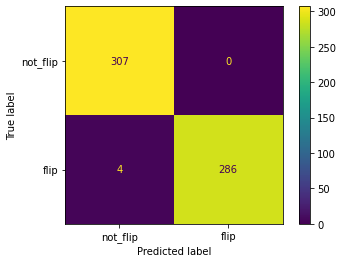

In [20]:
# Display the confusion matrix to evaluate the model

cm = confusion_matrix(y_test, binary_values)
cmd = ConfusionMatrixDisplay(cm, display_labels=['not_flip','flip'])
cmd.plot()

plt.show()

In [21]:
# Print the Classification report to get the precision, recall, f1-score

print(classification_report(y_test, binary_values))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       307
           1       1.00      0.99      0.99       290

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



I was able to create a model with 0.99 accuray if a page needs to whether be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the pages the same size, adjusting bright, adding nose, etc.

In [22]:

# Save the model using pickle

model_classifier = model.save('flip_page_classifier')

2022-05-09 11:34:32.579872: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: flip_page_classifier/assets
